In [1]:
import io
import itertools

import numpy as np
import sklearn.metrics

import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

from PIL import Image

import matplotlib.pyplot as plt

import matplotlib.image as mpimg

In [2]:
data_train = np.load(r"../Dataset/Primary categories - Train.npz")
data_val = np.load(r"../Dataset/Primary categories - Validation.npz")
data_test = np.load(r"../Dataset/Primary categories - Test.npz")

In [3]:
# Extracting the arrays from the imported data
images_train = data_train['images']
labels_train = data_train['labels']

images_val = data_val['images']
labels_val = data_val['labels']

images_test = data_test['images']
labels_test = data_test['labels']

In [4]:
images_train = images_train/255.0
images_val = images_val/255.0
images_test = images_test/255.0

In [5]:
EPOCHS = 15
BATCH_SIZE = 64

In [9]:
# Wrapping our model and training in a function
def train_test_model():
    
    # Outlining the model/architecture of our CNN
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(120,90,3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3)
    ])
    
    # Defining the loss function
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Compiling the model
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

    # Defining the logging directory
    log_dir = "Logs\\Model 1\\fit\\" + "run-good"
    
    
    def plot_confusion_matrix(cm, class_names):
        """
        Returns a matplotlib figure containing the plotted confusion matrix.

        Args:
          cm (array, shape = [n, n]): a confusion matrix of integer classes
          class_names (array, shape = [n]): String names of the integer classes
        """
        figure = plt.figure(figsize=(12, 12))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        # Normalize the confusion matrix.
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

        # Use white text if squares are dark; otherwise black.
        threshold = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return figure
    
    
    
    def plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image
    
    
    # Defining a file writer for Confusion Matrix logging purposes
    file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')     
    
    
    def log_confusion_matrix(epoch, logs):
        # Use the model to predict the values from the validation dataset.
        test_pred_raw = model.predict(images_val)
        test_pred = np.argmax(test_pred_raw, axis=1)

        # Calculate the confusion matrix.
        cm = sklearn.metrics.confusion_matrix(labels_val, test_pred)
        # Log the confusion matrix as an image summary.
        figure = plot_confusion_matrix(cm, class_names=['Glasses/Sunglasses', 'Trousers/Jeans', 'Shoes'])
        cm_image = plot_to_image(figure)

        # Log the confusion matrix as an image summary.
        with file_writer_cm.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)
    
    
    
    # Define the Tensorboard and Confusion Matrix callbacks.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)
    cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

    
    # Defining early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        mode = 'auto',
        min_delta = 0,
        patience = 2,
        verbose = 0, 
        restore_best_weights = True
    )
    
    # Training the model
    model.fit(
        images_train,
        labels_train,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        callbacks = [tensorboard_callback, cm_callback, early_stopping],
        validation_data = (images_val,labels_val),
        verbose = 2
    )
    
    
    # Evaluating the model's performance on the validation set
    _, accuracy = model.evaluate(images_val,labels_val)
    
    # Saving the current model for future reference
    model.save(r"ModelCategory.keras")
    
    return accuracy

In [10]:
#%load_ext tensorboard
#%tensorboard --logdir "Logs/Model 1/hparam_tuning"

res = train_test_model()

C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
203/203 - 13s - 66ms/step - accuracy: 0.9792 - loss: 0.0728 - val_accuracy: 0.9975 - val_loss: 0.0146
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
203/203 - 13s - 62ms/step - accuracy: 0.9988 - loss: 0.0136 - val_accuracy: 0.9981 - val_loss: 0.0173
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
203/203 - 12s - 59ms/step - accuracy: 0.9990 - loss: 0.0095 - val_accuracy: 0.9988 - val_loss: 0.0048
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
203/203 - 13s - 62ms/step - accuracy: 0.9987 - loss: 0.0090 - val_accuracy: 0.9957 - val_loss: 0.0247
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
203/203 - 12s - 60ms/step - accuracy: 0.9988 - loss: 0.0078 - val_accuracy: 0.9988 - val_loss: 0.0055
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9996 - loss: 0.0033


In [5]:
caption_model = tf.keras.models.load_model('ModelCategory.keras')

In [6]:
def load_image_from_path(img_path):
    image = Image.open(img_path)
    image = image.resize((120, 90))
    return np.asarray(image)/255


In [7]:
dict = {
  0: "Glasses/Sunglasses",
  1: "Trousers/Jeans",
  2: "Shoes"
}

In [12]:
path = 'ImagesNet/Jeans002.jpg'
res = load_image_from_path(path)

res = np.asarray([res])

res[0:1].shape


pred =  caption_model.predict(res)
label = np.argmax(pred)
print(dict[label])


image = mpimg.imread(path)
image = plt.imshow(image)

InvalidArgumentError: Graph execution error:

Detected at node convolution defined at (most recent call last):
<stack traces unavailable>
Depth of input must be a multiple of depth of filter: 4 vs 3

Stack trace for op definition: 
File "c:\Program Files\Python310\lib\runpy.py", line 196, in _run_module_as_main
File "c:\Program Files\Python310\lib\runpy.py", line 86, in _run_code
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 18, in <module>
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1075, in launch_instance
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 739, in start
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 205, in start
File "c:\Program Files\Python310\lib\asyncio\base_events.py", line 600, in run_forever
File "c:\Program Files\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
File "c:\Program Files\Python310\lib\asyncio\events.py", line 80, in _run
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 534, in process_one
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
File "C:\Users\F_Mota\AppData\Local\Temp\ipykernel_30264\2426496283.py", line 9, in <module>
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\backend\tensorflow\trainer.py", line 508, in predict
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\backend\tensorflow\trainer.py", line 208, in one_step_on_data_distributed
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\backend\tensorflow\trainer.py", line 198, in one_step_on_data
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\backend\tensorflow\trainer.py", line 96, in predict_step
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\layer.py", line 882, in __call__
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\ops\operation.py", line 46, in __call__
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 209, in call
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\models\functional.py", line 175, in call
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\models\functional.py", line 556, in call
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\layer.py", line 882, in __call__
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\ops\operation.py", line 46, in __call__
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py", line 243, in call
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py", line 233, in convolution_op
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\ops\nn.py", line 909, in conv
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\backend\tensorflow\nn.py", line 254, in conv
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\backend\tensorflow\nn.py", line 244, in _conv_xla
File "C:\Users\F_Mota\AppData\Roaming\Python\Python310\site-packages\keras\src\backend\tensorflow\nn.py", line 231, in _conv

	 [[{{node convolution}}]]
	tf2xla conversion failed while converting __inference__conv_xla_461[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[sequential_1_1/conv2d_2_1/StatefulPartitionedCall]] [Op:__inference_one_step_on_data_distributed_491]

In [9]:
data_ = np.load(r"../Dataset/Trousers & Jeans - All - Train.npz")

data_['labels'][10]

2

Calça de malha feminina


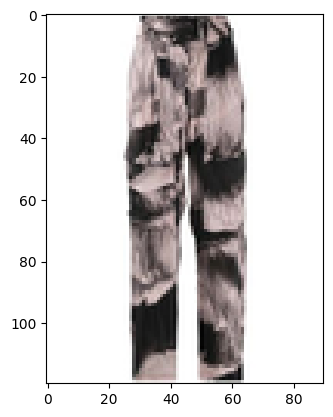

In [29]:
from random import randrange
num = randrange(4000)

dict_J_T = {
  0: "Trousers",
  1: "Jeans"
}

dict_ = {
  0: "Calça de malha masculina",
  1: "Jeans Masculino",
  2: "Calça de malha feminina",
  3: "Jeans Feminino"
}

#for i in range(100):
print(dict_[data_['labels'][num]])
  #print(i)

#data_['genders'][0]
#data_['labels'][0]
img = data_['images'][num]


img = Image.fromarray(img, 'RGB')
#from matplotlib import cm
#img = Image.fromarray(np.uint8(cm.gist_earth(img)))

plt.imshow(img)

In [30]:
test_loss, test_accuracy = caption_model.evaluate(images_test,labels_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9989 - loss: 0.0176
